In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

import sys
sys.path.insert(0, '../src')
from utils import *
from sklearn.cluster import KMeans

In [2]:
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
main_path = '../../dataset/'
gamma_path = 'GAMMAChallenge21Dados/'
data_path = '6. Assistencia Social/'
data_munic_path = '3. Atlas de Desenvolvimento Humano/'
data_file_cras = {'filename':'IDCRAS.xlsx', 'sheet_name':'dados'}
data_file_creas = {'filename':'IDCREAS.xlsx', 'sheet_name':'dados'}
data_file_rma = {'filename':'RMA.xlsx', 'sheet_name_cras':'dados_CRAS', 'sheet_name_creas':'dados_CREAS'}
data_file_munic = {'filename': 'Atlas 2013_municipal, estadual e Brasil.xlsx', 'sheet_name':'UF 91-00-10'}

In [62]:
NORDESTE = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
NORDESTE_nome = ['Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 'Piauí', 'Rio Grande do Norte', 'Sergipe']

# Intro

In [5]:
def normalize_municipio(df, column_name='nome_municipio'):
    df[column_name] = df[column_name].astype(str)
    df['nome_municipio_norm'] = df[column_name].apply(replace_accents)
    df['nome_municipio_norm'] = df['nome_municipio_norm'].apply(lambda x: re.sub(r"[^a-zA-Z\d\_]+", " ", x))
    df['nome_municipio_norm'] = df['nome_municipio_norm'].str.upper()
    return df

In [6]:
#mantém ultimo ano avaliado
def keep_data_last_year(df, column_name='ano'):
    return df[df[column_name] == df[column_name].max()]

In [7]:
def fill_rate(df):
     # Preparing dataframe to analyze features fill
    fill = pd.DataFrame(100*df.count().sort_values()/df.shape[0])
    fill.reset_index(level=0, inplace=True)
    fill.columns = ['Variable','Fill (%)']
    fill['Fill (%)'] = fill['Fill (%)'].astype(int)

    return fill

In [8]:
def plotting_group(grouped, xlabel, ylabel, figsize=(8,5), rot=0):
    ax = (grouped
      .count()
      .plot(kind='bar',
            figsize=figsize,
            rot=rot, 
            grid=True))

    ax.set_ylabel(xlabel);
    ax.set_xlabel(ylabel);

    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x(), p.get_height() + 200))

-----------
## CRAS indice

In [54]:
df_cras = pd.read_excel(main_path + gamma_path + data_path + data_file_cras['filename'], 
                        sheet_name = data_file_cras['sheet_name'])

In [55]:
df_cras = normalize_municipio(df_cras)

In [56]:
columns_to_keep = ['uf', 'nome_municipio', 'nome_municipio_norm', 'cod_ibge', 'ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']

In [57]:
#mantém ultimo ano avaliado
df_cras = keep_data_last_year(df_cras)

In [59]:
df_cras = df_cras[columns_to_keep]

In [60]:
# há cidades com mais de um nucleo CRAS
df_cras = (df_cras[df_cras['uf']
                   .isin(NORDESTE)]
           .groupby(['uf', 'nome_municipio', 'nome_municipio_norm', 'cod_ibge'])[
               ['ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']
           ]
           .mean())

In [61]:
inspect(df_cras);

shape: (1793, 4)
columns: ['ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']


ind_estru_fisic  \
uf nome_municipio         nome_municipio_norm    cod_ibge                    
AL Anadia                 ANADIA                 270020               4.00   
   Arapiraca              ARAPIRACA              270030               2.89   
   Atalaia                ATALAIA                270040               4.00   
   Barra de Santo Antônio BARRA DE SANTO ANTONIO 270050               5.00   
   Barra de São Miguel    BARRA DE SAO MIGUEL    270060               4.00   

                                                           ind_servi  ind_rh  \
uf nome_municipio         nome_municipio_norm    cod_ibge                      
AL Anadia                 ANADIA                 270020         3.00    5.00   
   Arapiraca              ARAPIRACA              270030         2.89    3.78   
   Atalaia                ATALAIA                270040         3.00    5.00   
   Barra de Santo Antônio BARRA DE SANTO ANTONIO 270050         1.00    4.00   
   Barra de São Miguel    BARRA DE SAO MIGUEL    270060         3.00    5.00   

                                                           id_cras.1  
uf nome_municipio         nome_municipio_norm    cod_ibge             
AL Anadia                 ANADIA                 270020         4.00  
   Arapiraca              ARAPIRACA              270030         3.19  
   Atalaia                ATALAIA                270040         4.00  
   Barra de Santo Antônio BARRA DE SANTO ANTONIO 270050         3.33  
   Barra de São Miguel    BARRA DE SAO MIGUEL    270060         4.00

In [16]:
indice_medio_cras_municipios = (
    df_cras.groupby(['nome_municipio', 
                     'nome_municipio_norm', 
                     'cod_ibge'])[['ind_estru_fisic', 
                                   'ind_servi', 'ind_rh', 
                                   'id_cras.1']]
    .mean()
    .reset_index()
)

In [17]:
indice_medio_cras_estados = (
    df_cras.groupby(['uf'])[['ind_estru_fisic', 
                             'ind_servi', 
                             'ind_rh', 
                             'id_cras.1']]
    .mean()
    .sort_values('uf')
)

-----------
### CRAS RMA

In [18]:
df_registros_cras = pd.read_excel(main_path + gamma_path + data_path + data_file_rma['filename'], 
                                  sheet_name = data_file_rma['sheet_name_cras'])

In [19]:
#mantém ultimo ano avaliado
df_registros_cras = keep_data_last_year(df_registros_cras)

In [20]:
df_registros_cras = normalize_municipio(df_registros_cras)

In [21]:
df_registros_cras.columns

Index(['ano', 'mes_referencia', 'regiao', 'uf', 'cod_ibge', 'nome_municipio',
       'porte_municipio', 'nome_unidade', 'numero_cras', 'endereco_cras', 'a1',
       'a2', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'c4', 'c5',
       'c6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'nome_municipio_norm'],
      dtype='object')

In [22]:
df_registros_cras = df_registros_cras[df_registros_cras['uf'].isin(NORDESTE)]
df_registros_cras_grouped = df_registros_cras.groupby(['uf', 'nome_municipio_norm'])[
    ['cod_ibge', 
     'a1', 'a2', 
     'b1', 'b2', 'b3', 'b5', 'b6', #'b4'
     'c1', 'c6', #'c2', 'c3', 'c4', 'c5'
     'd1', 'd4', #'d2', 'd3', 'd5', 'd6', 'd7'
    ]
].mean().fillna(0).astype(int)

In [23]:
df_registros_cras_grouped = (df_registros_cras_grouped
                     .rename(columns = {
                         'a1': 'total_familias_acompanha_paif', 
                         'a2': 'novas_familias_acompanha_paif',
                         'b1': 'familias_paif_ext_pobre',
                         'b2': 'familias_paif_bolsa_familia',
                         'b3': 'familias_paif_bolsa_familia_irreg',
                         'b5': 'familias_paif_trab_infantil',
                         'b6': 'familias_paif_acolhida',
                         'c1': 'atend_individ_por_mes',
                         'c6': 'atend_individ_domicilio',
                         'd1': 'atend_coletiv_familias_paif',
                         'd4': 'atend_coletiv_adolescentes'
                     }, inplace = False))

In [24]:
df_registros_cras_grouped.head()

cod_ibge  total_familias_acompanha_paif  \
uf nome_municipio_norm                                               
AL  GUA BRANCA               270010                            300   
   ANADIA                    270020                              7   
   ARAPIRACA                 270030                             59   
   ATALAIA                   270040                            441   
   BARRA DE SANTO ANTONIO    270050                            174   

                           novas_familias_acompanha_paif  \
uf nome_municipio_norm                                     
AL  GUA BRANCA                                         6   
   ANADIA                                              2   
   ARAPIRACA                                          11   
   ATALAIA                                            16   
   BARRA DE SANTO ANTONIO                              2   

                           familias_paif_ext_pobre  \
uf nome_municipio_norm                               
AL  GUA BRANCA                                   3   
   ANADIA                                        1   
   ARAPIRACA                                     2   
   ATALAIA                                      14   
   BARRA DE SANTO ANTONIO                        1   

                           familias_paif_bolsa_familia  \
uf nome_municipio_norm                                   
AL  GUA BRANCA                                       0   
   ANADIA                                            2   
   ARAPIRACA                                         5   
   ATALAIA                                          14   
   BARRA DE SANTO ANTONIO                            1   

                           familias_paif_bolsa_familia_irreg  \
uf nome_municipio_norm                                         
AL  GUA BRANCA                                             0   
   ANADIA                                                  0   
   ARAPIRACA                                               0   
   ATALAIA                                                 0   
   BARRA DE SANTO ANTONIO                                  0   

                           familias_paif_trab_infantil  \
uf nome_municipio_norm                                   
AL  GUA BRANCA                                       0   
   ANADIA                                            0   
   ARAPIRACA                                         0   
   ATALAIA                                           0   
   BARRA DE SANTO ANTONIO                            0   

                           familias_paif_acolhida  atend_individ_por_mes  \
uf nome_municipio_norm                                                     
AL  GUA BRANCA                                  0                     12   
   ANADIA                                       0                     56   
   ARAPIRACA                                    0                    237   
   ATALAIA                                      0                     64   
   BARRA DE SANTO ANTONIO                       0                     15   

                           atend_individ_domicilio  \
uf nome_municipio_norm                               
AL  GUA BRANCA                                   8   
   ANADIA                                        9   
   ARAPIRACA                                    47   
   ATALAIA                                      30   
   BARRA DE SANTO ANTONIO                        1   

                           atend_coletiv_familias_paif  \
uf nome_municipio_norm                                   
AL  GUA BRANCA                                     112   
   ANADIA                                            0   
   ARAPIRACA                                        10   
   ATALAIA                                         468   
   BARRA DE SANTO ANTONIO                          137   

                           atend_coletiv_adolescentes  
uf nome_municipio_norm                                 
AL  GUA BRANCA                            

In [25]:
trabalhos_cras_estados = (
    df_registros_cras_grouped.groupby(['uf'])[['total_familias_acompanha_paif',
                                               'novas_familias_acompanha_paif',
                                               'familias_paif_ext_pobre',
                                               'familias_paif_bolsa_familia',
                                               'familias_paif_bolsa_familia_irreg',
                                               'familias_paif_trab_infantil',
                                               'familias_paif_acolhida',
                                               'atend_individ_por_mes',
                                               'atend_individ_domicilio',
                                               'atend_coletiv_familias_paif',
                                               'atend_coletiv_adolescentes']]
    .mean()
    .sort_values('uf')
)

In [26]:
inspect(trabalhos_cras_estados);

shape: (9, 11)
columns: ['total_familias_acompanha_paif', 'novas_familias_acompanha_paif', 'familias_paif_ext_pobre', 'familias_paif_bolsa_familia', 'familias_paif_bolsa_familia_irreg', 'familias_paif_trab_infantil', 'familias_paif_acolhida', 'atend_individ_por_mes', 'atend_individ_domicilio', 'atend_coletiv_familias_paif', 'atend_coletiv_adolescentes']


,total_familias_acompanha_paif,novas_familias_acompanha_paif,familias_paif_ext_pobre,familias_paif_bolsa_familia,familias_paif_bolsa_familia_irreg,familias_paif_trab_infantil,familias_paif_acolhida,atend_individ_por_mes,atend_individ_domicilio,atend_coletiv_familias_paif,atend_coletiv_adolescentes
uf,,,,,,,,,,,
AL,148.75,10.99,4.11,8.96,1.78,0.35,0.67,60.31,16.97,65.84,70.98
BA,254.23,11.99,3.83,8.04,1.82,0.30,0.21,100.14,21.91,103.75,55.85
CE,133.40,4.42,1.55,3.14,0.76,0.02,0.02,96.22,27.70,44.73,52.10
MA,262.79,16.22,4.77,9.77,2.63,0.98,0.47,79.67,20.40,104.00,65.72
PB,262.49,12.07,4.75,8.18,1.54,0.29,0.21,73.09,15.41,95.26,45.81


-----------
## CREAS indice

In [27]:
df_creas = pd.read_excel(main_path + gamma_path + data_path + data_file_creas['filename'], 
                        sheet_name = data_file_creas['sheet_name'])

In [28]:
df_creas = normalize_municipio(df_creas)

In [29]:
columns_to_keep = ['uf', 
                   'nome_municipio', 
                   'nome_municipio_norm', 
                   'cod_ibge', 
                   'ind_estru_fisic', 
                   'ind_servi', 
                   'ind_rh', 
                   'id_creas.1']

In [30]:
#mantém ultimo ano avaliado
df_creas = keep_data_last_year(df_creas)

In [31]:
df_creas = df_creas[columns_to_keep]

In [32]:
# há cidades com mais de um nucleo CREAS
df_creas = (df_creas[df_creas['uf']
                   .isin(NORDESTE)]
           .groupby(['uf', 
                     'nome_municipio', 
                     'nome_municipio_norm', 
                     'cod_ibge'])[['ind_estru_fisic', 
                                   'ind_servi', 
                                   'ind_rh', 
                                   'id_creas.1']]
           .mean())

In [33]:
inspect(df_creas);

shape: (945, 4)
columns: ['ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_creas.1']


ind_estru_fisic  \
uf nome_municipio         nome_municipio_norm    cod_ibge                    
AL Anadia                 ANADIA                 270020               4.00   
   Arapiraca              ARAPIRACA              270030               4.00   
   Atalaia                ATALAIA                270040               3.00   
   Barra de Santo Antônio BARRA DE SANTO ANTONIO 270050               3.00   
   Barra de São Miguel    BARRA DE SAO MIGUEL    270060               3.00   

                                                           ind_servi  ind_rh  \
uf nome_municipio         nome_municipio_norm    cod_ibge                      
AL Anadia                 ANADIA                 270020         3.00    1.00   
   Arapiraca              ARAPIRACA              270030         2.00    4.00   
   Atalaia                ATALAIA                270040         5.00    3.00   
   Barra de Santo Antônio BARRA DE SANTO ANTONIO 270050         1.00    1.00   
   Barra de São Miguel    BARRA DE SAO MIGUEL    270060         5.00    2.00   

                                                           id_creas.1  
uf nome_municipio         nome_municipio_norm    cod_ibge              
AL Anadia                 ANADIA                 270020          2.67  
   Arapiraca              ARAPIRACA              270030          3.33  
   Atalaia                ATALAIA                270040          3.67  
   Barra de Santo Antônio BARRA DE SANTO ANTONIO 270050          1.67  
   Barra de São Miguel    BARRA DE SAO MIGUEL    270060          3.33

In [34]:
indice_medio_creas_municipios = (
    df_creas.groupby(['nome_municipio', 
                      'nome_municipio_norm', 
                      'cod_ibge'])[['ind_estru_fisic', 
                                    'ind_servi', 
                                    'ind_rh', 
                                    'id_creas.1']]
    .mean()
    .reset_index()
)

In [35]:
indice_medio_creas_estados = (
    df_creas.groupby(['uf'])[['ind_estru_fisic', 
                              'ind_servi',
                              'ind_rh', 
                              'id_creas.1']]
    .mean()
    .sort_values('id_creas.1', ascending=False)
)

## Target Population

In [36]:
ibge_municipio = pd.read_parquet(main_path + 'public/ibge_municipio_pib.parquet')

ibge_municipio['municipioCodigo'] = ibge_municipio['municipioCodigo'].astype(str)
ibge_municipio['municipioCodigo6d'] = ibge_municipio['municipioCodigo'].str.slice(0, 6)

ibge_municipio['nomeMunicipioNorm'] = ibge_municipio['nomeMunicipio'].apply(replace_accents)
ibge_municipio['nomeMunicipioNorm'] = ibge_municipio['nomeMunicipioNorm'].apply(lambda x: re.sub(r"[^a-zA-Z\d\_]+", " ", x))
ibge_municipio['nomeMunicipioNorm'] = ibge_municipio['nomeMunicipioNorm'].str.upper()

ibge_municipio = ibge_municipio[['uf',
                                 'ufCodigo',
                                 'nomeUf', 
                                 'nomeMunicipio', 
                                 'nomeMunicipioNorm',
                                 'municipioCodigo', 
                                 'municipioCodigo6d']]

ibge_municipio = ibge_municipio.drop_duplicates()

inspect(ibge_municipio);

shape: (5570, 7)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d
0,RO,11,Rondônia,Alta Floresta D'Oeste,ALTA FLORESTA D OESTE,1100015,110001
1,RO,11,Rondônia,Ariquemes,ARIQUEMES,1100023,110002
2,RO,11,Rondônia,Cabixi,CABIXI,1100031,110003
3,RO,11,Rondônia,Cacoal,CACOAL,1100049,110004
4,RO,11,Rondônia,Cerejeiras,CEREJEIRAS,1100056,110005


In [37]:
sim_pf_homcidios = pd.read_csv(
    main_path + gamma_path + '1. SIM (Homicidios)/DadosHomicidios_2013-18_SIM.csv',
    dtype={'dtnasc': str},
    low_memory=False
)

sim_pf_homcidios.columns = sim_pf_homcidios.columns.str.lower()

sim_pf_homcidios['codmunocor'] = sim_pf_homcidios['codmunocor'].astype(str)

# sim_pf_homcidios['dtnasc'] = sim_pf_homcidios['dtnasc'].astype(int).astype(str).pad(8, fillchar='0')

# Data em que occoreu o óbito
sim_pf_homcidios['dtobito'] = pd.to_datetime((sim_pf_homcidios['dtobito'].astype(int).astype(str)).str.pad(8, fillchar='0'), format='%d%m%Y')

# Horário do óbito.
sim_pf_homcidios['horaobito'] = sim_pf_homcidios['horaobito'].fillna(-9999)
sim_pf_homcidios['horaobito'] = (sim_pf_homcidios['horaobito'].astype(int).astype(str)).str.pad(4, fillchar='0')
sim_pf_homcidios['horaobito'] = (sim_pf_homcidios['horaobito'].str.slice(0, 2).astype(int) * 60 + sim_pf_homcidios['horaobito'].str.slice(2, 4).astype(int))/float(60)
sim_pf_homcidios['horaobito'] = np.where(sim_pf_homcidios['horaobito'] < 0, np.nan, sim_pf_homcidios['horaobito'])

# Tipo de morte violenta ou circunstâncias em que se deu a morte não  natural
circobito_map = {1: "acidente", 2: "suicídio", 3: "homicídio", 4: "outros", 9: "ignorado"}

# Sexo do falecido
sexo_map = {0: "ignorado", 1: "masculino", 2: "feminino"}

# Cor informada pelo responsável pelas informações do falecido.
racacor_map = {1: "Branca", 2: "Preta", 3: "Amarela", 4: "Parda", 5: "Indígena"}

# Local de ocorrência do óbito.
lococor_map = {
    1: "hospital", 2: "outros estabelecimentos de saúde", 3: "domicílio",
    4: "via pública", 5: "outros", 6: "aldeia indígena", 9: "ignorado"
}

# Se refere ao atendimento médico continuado que o paciente recebeu,  ou não , durante a enfermidade que ocasionou o óbito.
assistmed_map = {1: "sim", 2: "não", 9: "ignorado"}

# col maps
sim_pf_homcidios = sim_pf_homcidios.replace({
    "circobito": circobito_map,
    "sexo": sexo_map,
    "racacor": racacor_map,
    "lococor": lococor_map,
    "assistmed": assistmed_map,
})

# map UFs
sim_pf_homcidios = (
    sim_pf_homcidios
    .merge(ibge_municipio.rename(columns={'municipioCodigo6d': 'codmunocor'}), on='codmunocor')
)

# O primeiro, de 1 dígito, indica a unidade da idade (se 1 = minuto, se 2 = hora, se 3 = mês, se 4 = ano,  se = 5 idade maior que 100 anos)
# Anos - subcampo varia de 00 a 99; - 9 - ignorado)
# Homicídios de Jovens (15 a 29 anos)
sim_pf_homcidios = sim_pf_homcidios[(sim_pf_homcidios['idade'] >= 400) & (sim_pf_homcidios['idade'] < 500)]
sim_pf_homcidios['idade'] = (sim_pf_homcidios['idade'].astype(str).str.slice(1, 3)).astype(int)
sim_pf_homcidios = sim_pf_homcidios[(sim_pf_homcidios['idade'] >= 15) & (sim_pf_homcidios['idade'] < 30)]

# considerando apenas homicídios
sim_pf_homcidios = sim_pf_homcidios[sim_pf_homcidios['circobito'] == 'homicídio']

# removendo variaveis com preenchimento muito baixo (<20%)
sim_pf_homcidios_fill_rate = fill_rate(sim_pf_homcidios)
sim_pf_homcidios_low_fill_rate_cols = sim_pf_homcidios_fill_rate[sim_pf_homcidios_fill_rate['Fill (%)'] < 20]['Variable'].tolist()
sim_pf_homcidios_cols = [i for i in sim_pf_homcidios.columns.tolist() if i not in sim_pf_homcidios_low_fill_rate_cols]
sim_pf_homcidios = sim_pf_homcidios[sim_pf_homcidios_cols]

In [38]:
sim_pf_homcidios = sim_pf_homcidios[sim_pf_homcidios['uf'].isin(NORDESTE)]

In [39]:
# numerolote, contador, linhac

inspect(sim_pf_homcidios);

shape: (80198, 54)
columns: ['contador', 'origem', 'tipobito', 'dtobito', 'horaobito', 'natural', 'dtnasc', 'idade', 'sexo', 'racacor', 'estciv', 'esc', 'esc2010', 'seriescfal', 'ocup', 'codmunres', 'lococor', 'codestab', 'codmunocor', 'assistmed', 'necropsia', 'linhaa', 'linhab', 'linhac', 'causabas', 'comunsvoim', 'dtatestado', 'circobito', 'fonte', 'tppos', 'dtinvestig', 'causabas_o', 'dtcadastro', 'atestante', 'fonteinv', 'dtrecebim', 'difdata', 'stdoepidem', 'stdonova', 'codmunnatu', 'numerolote', 'stcodifica', 'codificado', 'versaosist', 'versaoscb', 'atestado', 'dtrecoriga', 'escfalagr1', 'uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo']


,contador,origem,tipobito,dtobito,horaobito,natural,dtnasc,idade,sexo,racacor,estciv,esc,esc2010,seriescfal,ocup,codmunres,lococor,codestab,codmunocor,assistmed,necropsia,linhaa,linhab,linhac,causabas,comunsvoim,dtatestado,circobito,fonte,tppos,dtinvestig,causabas_o,dtcadastro,atestante,fonteinv,dtrecebim,difdata,stdoepidem,stdonova,codmunnatu,numerolote,stcodifica,codificado,versaosist,versaoscb,atestado,dtrecoriga,escfalagr1,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo
2027,68,1,2,2013-02-27,NaN,NaN,30121989.00,23,masculino,Parda,9.00,9.00,9.00,NaN,NaN,270240,outros,NaN,292530,não,1.00,*S069,*X959,NaN,X959,292530.00,15032013.00,homicídio,1.00,NaN,NaN,X959,24042013.00,3.00,NaN,10092014.00,64.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BA,29,Bahia,Porto Seguro,PORTO SEGURO,2925303
2029,1258,1,2,2013-01-17,17.00,NaN,18081997.00,15,masculino,Parda,1.00,2.00,1.00,NaN,NaN,292530,via pública,NaN,292530,não,1.00,*T07X,*X954,NaN,X954,292530.00,18012013.00,homicídio,1.00,NaN,NaN,X954,25022013.00,3.00,NaN,10092014.00,46.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BA,29,Bahia,Porto Seguro,PORTO SEGURO,2925303
2031,1262,1,2,2013-01-26,20.50,NaN,6071994.00,18,masculino,Parda,1.00,2.00,1.00,NaN,NaN,292770,outros,NaN,292530,não,1.00,*S099,NaN,NaN,X959,292530.00,27012013.00,homicídio,1.00,NaN,NaN,X959,21022013.00,3.00,NaN,10092014.00,37.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BA,29,Bahia,Porto Seguro,PORTO SEGURO,2925303
2032,1264,1,2,2013-01-18,NaN,NaN,30011986.00,26,masculino,Preta,1.00,2.00,1.00,NaN,NaN,292530,outros,NaN,292530,não,1.00,*S069,*X959,NaN,X959,292530.00,30012013.00,homicídio,1.00,NaN,NaN,X959,25022013.00,3.00,NaN,10092014.00,45.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BA,29,Bahia,Porto Seguro,PORTO SEGURO,2925303
2033,1266,1,2,2013-02-04,23.00,NaN,6071989.00,23,feminino,Parda,1.00,2.00,1.00,NaN,NaN,292530,via pública,NaN,292530,não,1.00,*X914,NaN,NaN,X914,292530.00,5022013.00,homicídio,1.00,S,8042014.00,X914,27112013.00,3.00,8.00,12122014.00,301.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BA,29,Bahia,Porto Seguro,PORTO SEGURO,2925303


-------------

In [63]:
info_estados = pd.read_excel(main_path + gamma_path + data_munic_path + data_file_munic['filename'], 
                        sheet_name = data_file_munic['sheet_name'])

In [64]:
info_estados = keep_data_last_year(info_estados, 'ANO')

In [67]:
info_estados = info_estados[info_estados.UFN.isin(NORDESTE_nome)]

In [68]:
inspect(info_estados);

shape: (9, 235)
columns: ['ANO', 'UF', 'UFN', 'ESPVIDA', 'FECTOT', 'MORT1', 'MORT5', 'RAZDEP', 'SOBRE40', 'SOBRE60', 'T_ENV', 'E_ANOSESTUDO', 'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24', 'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'T_ATRASO_0_BASICO', 'T_ATRASO_0_FUND', 'T_ATRASO_0_MED', 'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED', 'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED', 'T_FBBAS', 'T_FBFUND', 'T_FBMED', 'T_FBPRE', 'T_FBSUPER', 'T_FLBAS', 'T_FLFUND', 'T_FLMED', 'T_FLPRE', 'T_FLSUPER', 'T_FREQ0A3', 'T_FREQ11A14', 'T_FREQ15A17', 'T_FREQ18A24', 'T_FREQ25A29', 'T_FREQ4A5', 'T_FREQ4A6', 'T_FREQ5A6', 'T_FREQ6', 'T_FREQ6A14', 'T_FREQ6A17', 'T_FREQFUND1517', 'T_FREQFUND1824', 'T_FREQFUND45', 'T_FREQMED1824', 'T_FREQMED614', 'T_FREQSUPER1517', 'T_FUND11A13', 'T_FUND12A14', 'T_FUND15A17', 'T_FUND16A18', 'T_FUND18A24', 'T_FUND18M', 'T_FUND25M', 'T_MED18A20', 'T_MED18A24', 'T_MED18M', 'T_MED19A21', 'T_MED25M', 'T_SUPER25M', 'CORTE1', 'CORTE2', 'CORTE

,ANO,UF,UFN,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,T_FREQ0A3,T_FREQ11A14,T_FREQ15A17,T_FREQ18A24,T_FREQ25A29,T_FREQ4A5,T_FREQ4A6,T_FREQ5A6,T_FREQ6,T_FREQ6A14,T_FREQ6A17,T_FREQFUND1517,T_FREQFUND1824,T_FREQFUND45,T_FREQMED1824,T_FREQMED614,T_FREQSUPER1517,T_FUND11A13,T_FUND12A14,T_FUND15A17,T_FUND16A18,T_FUND18A24,T_FUND18M,T_FUND25M,T_MED18A20,T_MED18A24,T_MED18M,T_MED19A21,T_MED25M,T_SUPER25M,CORTE1,CORTE2,CORTE3,CORTE4,CORTE9,GINI,PIND,PINDCRI,PMPOB,PMPOBCRI,PPOB,PPOBCRI,PREN10RICOS,PREN20,PREN20RICOS,PREN40,PREN60,PREN80,PRENTRAB,R1040,R2040,RDPC,RDPC1,RDPC10,RDPC2,RDPC3,RDPC4,RDPC5,RDPCT,RIND,RMPOB,RPOB,THEIL,CPR,EMP,P_AGRO,P_COM,P_CONSTR,P_EXTR,P_FORMAL,P_FUND,P_MED,P_SERV,P_SIUP,P_SUPER,P_TRANSF,REN0,REN1,REN2,REN3,REN5,RENOCUP,T_ATIV,T_ATIV1014,T_ATIV1517,T_ATIV1824,T_ATIV18M,T_ATIV2529,T_DES,T_DES1014,T_DES1517,T_DES1824,T_DES18M,T_DES2529,THEILtrab,TRABCC,TRABPUB,TRABSC,T_AGUA,T_BANAGUA,T_DENS,T_LIXO,T_LUZ,AGUA_ESGOTO,PAREDE,T_CRIFUNDIN_TODOS,T_FORA4A5,T_FORA6A14,T_FUNDIN_TODOS,T_FUNDIN_TODOS_MMEIO,T_FUNDIN18MINF,T_M10A14CF,T_M15A17CF,T_MULCHEFEFIF014,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,T_RMAXIDOSO,T_SLUZ,HOMEM0A4,HOMEM10A14,HOMEM15A19,HOMEM20A24,HOMEM25A29,HOMEM30A34,HOMEM35A39,HOMEM40A44,HOMEM45A49,HOMEM50A54,HOMEM55A59,HOMEM5A9,HOMEM60A64,HOMEM65A69,HOMEM70A74,HOMEM75A79,HOMEMTOT,HOMENS80,MULH0A4,MULH10A14,MULH15A19,MULH20A24,MULH25A29,MULH30A34,MULH35A39,MULH40A44,MULH45A49,MULH50A54,MULH55A59,MULH5A9,MULH60A64,MULH65A69,MULH70A74,MULH75A79,MULHER80,MULHERTOT,PEA,PEA1014,PEA1517,PEA18M,peso1,PESO1114,PESO1113,PESO1214,peso13,PESO15,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R
61,2010,21,Maranhão,70.40,2.56,28.03,30.61,58.65,93.45,82.45,6.02,9.26,7.59,4.73,20.87,6.38,22.51,11.17,27.15,54.91,59.87,64.52,19.91,19.94,25.77,25.18,20.19,9.70,107.17,117.95,74.37,76.13,16.09,89.62,93.35,38.14,57.49,6.97,20.33,95.59,83.15,30.15,13.15,88.21,90.56,93.85,95.43,96.25,93.01,35.85,5.77,24.40,11.15,1.40,0.50,81.56,84.86,47.84,57.47,64.56,44.36,38.53,29.60,35.49,28.40,35.66,26.36,5.43,57.80,142.75,244.89,434.20,677.60,0.62,22.47,31.42,39.53,53.43,63.58,77.47,50.06,1.34,64.85,7.00,17.44,35.15,71.74,28.61,18.53,360.34,24.21,1803.95,101.92,188.09,319.08,1168.32,373.40,28.61,62.13,113.11,0.74,28.09,0.95,30.45,14.91,8.34,0.46,33.20,51.08,35.20,36.07,0.69,7.17,4.96,16.73,48.74,85.24,91.32,95.55,735.96,49.28,9.53,24.32,55.24,58.78,66.16,8.99,11.98,17.30,17.19,8.56,10.61,0.58,22.86,6.28,28.13,82.12,51.79,42.70,79.08,96.10,23.99,24.92,42.56,11.79,3.75,34.72,27.91,50.99,0.67,10.38,26.94,21.56,3.34,5.54,3.90,322491,367451,343012,326817,293601,245825,197752,173251,147551,123305,103290,343766,84051,67114,51196,34466,3261515,36576,312910,357576,339239,329948,301572,254730,205619,182285,157769,133670,112796,329882,88292,69987,55175,36751,45073,3313274,2594571.00,69132.00,100920.00,2424519.00,119888,570208,425969,430422,382669,4536475,417090,1337753,411882,4119385,396218,920663,389424,3198722,132328,134487,131936,692870,1544711,396009,357302,207312,2311315,1642604,2427640,6574789,4147149,5264736.00,725332.00,414954.00,4124450.00,6547083,6317987,0.44,0.63,0.64,0.56,0.76,0.61
62,2010,22,Piauí,71.62,1.99,23.05,24.98,51.70,94.61,84.51,7.44,9.23,6.50,4.32,22.92,6.00,24.55,11.42,29.16,51.59,56.82,62.27,20.48,20.63,27.10,27.93,22.55,10.63,110.05,120.28,80.66,72.98,25.37,91.43,95.18,37.85,56.76,12.29,20.22,97.04,85.45,36.41,16.10,89.33,91.88,95.24,97.03,97.58,94.45,39.06,5.37,21.05,12.58,1.30,0.95,80.

In [292]:
mortes_estados = sim_pf_homcidios.groupby('uf')['uf'].count().to_dict()
mortes_estados_norm = dict()

for estado in info_estados.UFN.sort_values().to_list():
    
    mortes_estados_norm[estado] = (sim_pf_homcidios[sim_pf_homcidios.nomeUf == estado].groupby('uf')['uf'].count().values[0] / 
                             info_estados[info_estados.UFN == estado].POP.values[0])*100
mortes_estados_norm = pd.DataFrame.from_dict(mortes_estados_norm, orient='index', columns=['mortes_norm'])

## Target Users

---------

## Hypothesis

### Hypothesis 2

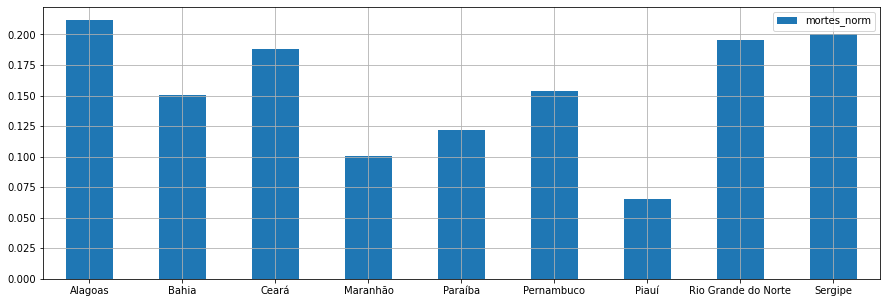

In [310]:
ax = mortes_estados_norm.plot(kind='bar',
        figsize=(15,5),
        rot=0, 
        grid=True)


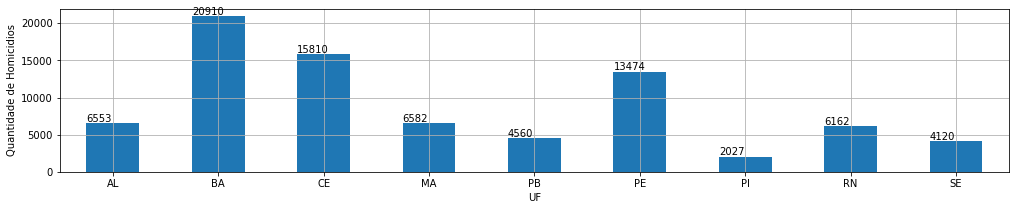

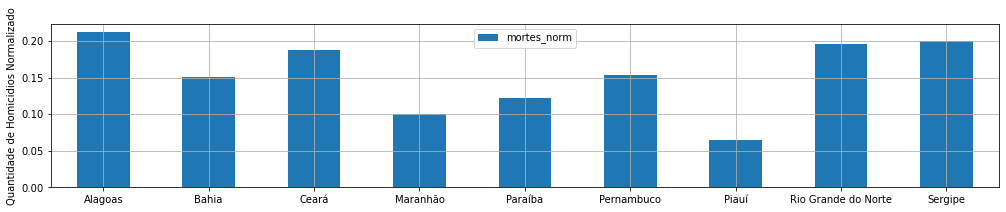

In [316]:
plotting_group(sim_pf_homcidios.groupby('uf')['uf'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='UF',
               figsize=(17,3))

ax = mortes_estados_norm.plot(kind='bar',
        figsize=(17,3),
        rot=0, 
        grid=True).set_ylabel("Quantidade de Homicidios Normalizado")

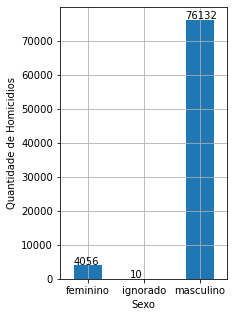

In [45]:
plotting_group(sim_pf_homcidios.groupby('sexo')['sexo'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='Sexo',
               figsize=(3,5))

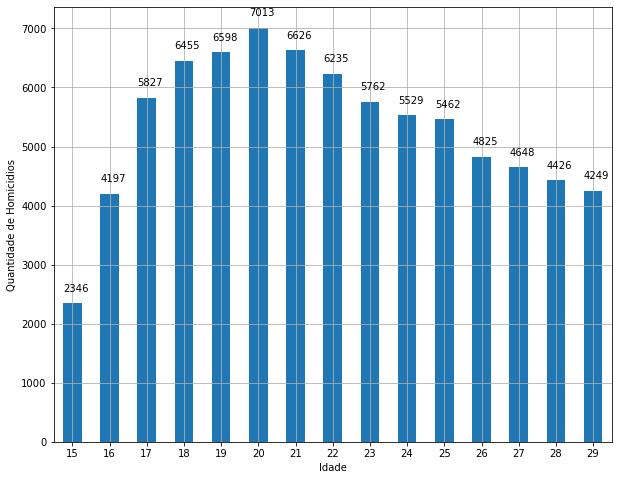

In [46]:
plotting_group(sim_pf_homcidios.groupby('idade')['idade'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='Idade',
               figsize=(10,8))

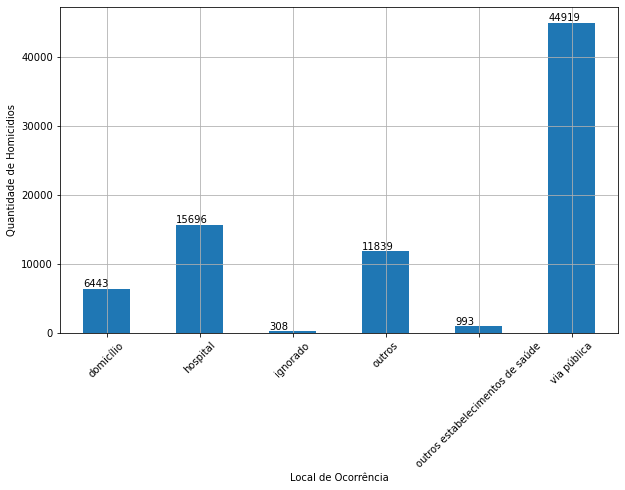

In [47]:
plotting_group(sim_pf_homcidios.groupby('lococor')['lococor'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='Local de Ocorrência',
               figsize=(10,6),
               rot=45)

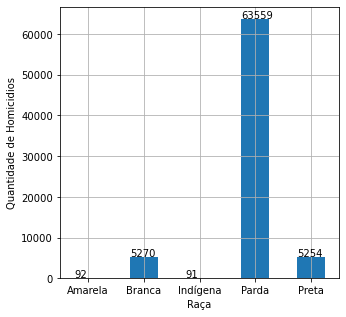

In [48]:
plotting_group(sim_pf_homcidios.groupby('racacor')['racacor'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='Raça',
               figsize=(5,5))

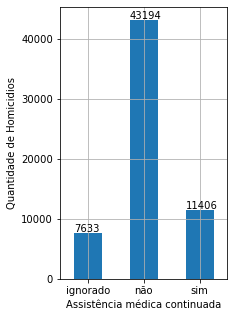

In [49]:
plotting_group(sim_pf_homcidios.groupby('assistmed')['assistmed'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='Assistência médica continuada',
               figsize=(3,5))

#### (2.1) Regiões com CRAS/CREAS suportam moradores com dificuldade

<AxesSubplot:title={'center':'Registro de Atividades - CRAS'}, xlabel='UF', ylabel='Registros'>

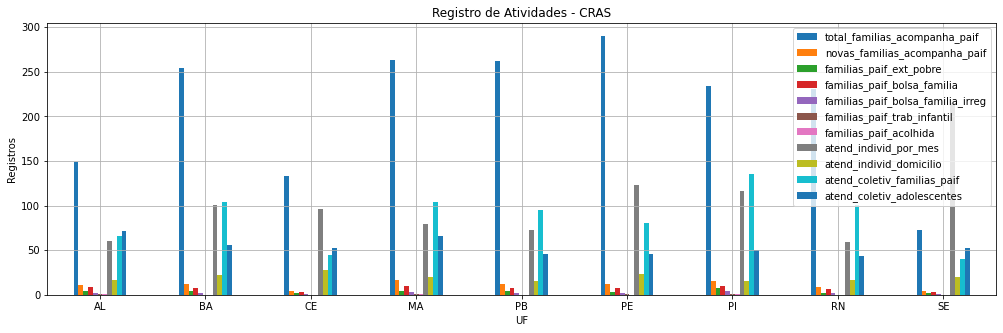

In [50]:
trabalhos_cras_estados.plot(kind='bar', 
                                title='Registro de Atividades - CRAS',
                                figsize=(17,5), 
                                ylabel='Registros',
                                xlabel='UF',
                                rot=0, 
                                grid=True)

In [51]:
trabalhos_cras_estados.columns

Index(['total_familias_acompanha_paif', 'novas_familias_acompanha_paif',
       'familias_paif_ext_pobre', 'familias_paif_bolsa_familia',
       'familias_paif_bolsa_familia_irreg', 'familias_paif_trab_infantil',
       'familias_paif_acolhida', 'atend_individ_por_mes',
       'atend_individ_domicilio', 'atend_coletiv_familias_paif',
       'atend_coletiv_adolescentes'],
      dtype='object')

In [353]:
trabalhos_cras_estados_extpobres = trabalhos_cras_estados[['familias_paif_ext_pobre']]


trabalhos_cras_estados_atendimento = trabalhos_cras_estados[['atend_coletiv_familias_paif',
                                                        'atend_coletiv_adolescentes'
                                                       ]]

trabalhos_cras_estados_acompanha = trabalhos_cras_estados[['familias_paif_trab_infantil',
'familias_paif_acolhida'
                                                       ]]



<AxesSubplot:title={'center':'Indice Médio Avaliativo - CRAS'}, xlabel='UF', ylabel='Valor de Indice Avaliativo Geral'>

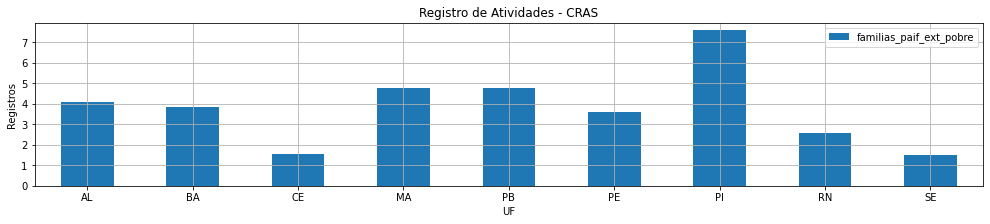

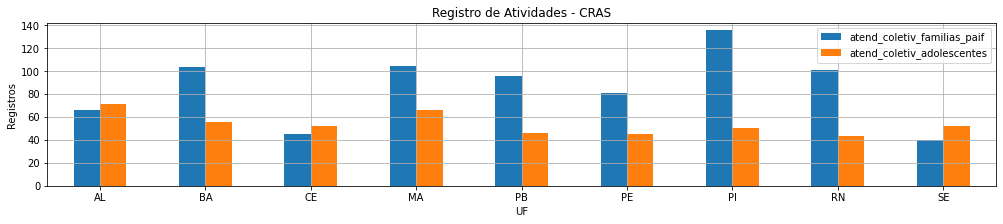

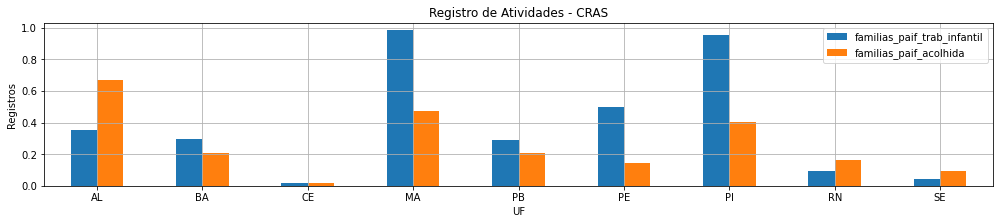

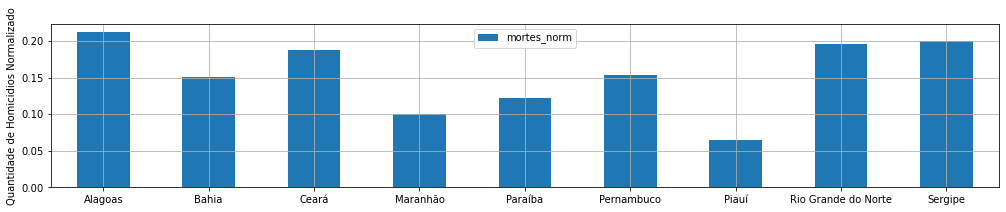

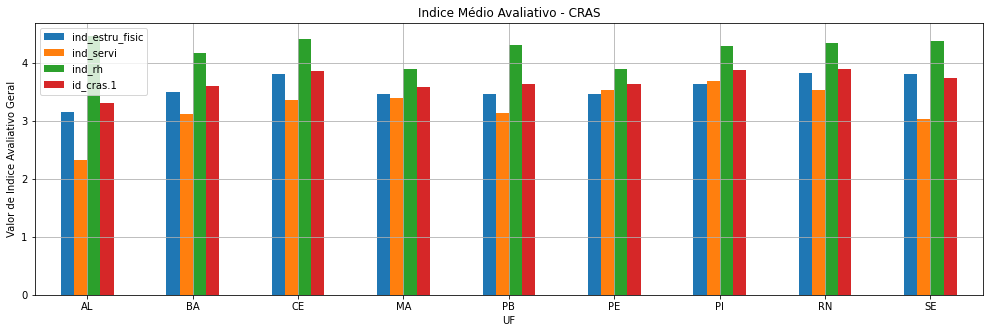

In [354]:
# plotting_group(sim_pf_homcidios.groupby('uf')['uf'], 
#                xlabel='Quantidade de Homicidios', 
#                ylabel='UF',
#                figsize=(17,5))


trabalhos_cras_estados_extpobres.plot(kind='bar', 
                                title='Registro de Atividades - CRAS',
                                figsize=(17,3), 
                                ylabel='Registros',
                                xlabel='UF',
                                rot=0, 
                                grid=True)


trabalhos_cras_estados_atendimento.plot(kind='bar', 
                                title='Registro de Atividades - CRAS',
                                figsize=(17,3), 
                                ylabel='Registros',
                                xlabel='UF',
                                rot=0, 
                                grid=True)

trabalhos_cras_estados_acompanha.plot(kind='bar', 
                                title='Registro de Atividades - CRAS',
                                figsize=(17,3), 
                                ylabel='Registros',
                                xlabel='UF',
                                rot=0, 
                                grid=True)


mortes_estados_norm.plot(kind='bar',
        figsize=(17,3),
        rot=0, 
        grid=True).set_ylabel("Quantidade de Homicidios Normalizado")


indice_medio_cras_estados.plot(kind='bar', 
                                title='Indice Médio Avaliativo - CRAS',
                                figsize=(17,5), 
                                ylabel='Valor de Indice Avaliativo Geral',
                                xlabel='UF',
                                rot=0, 
                                grid=True)


> Famílias em situação de extrema pobreza
- os 3 estados que **possuem MAIORES INDICES** de famílias em situação de extrema pobreza são os estados com **MENORES INDICES DE VIOLENCIA**
- em oposição, dos 3 estados que possuem MENORES INDICES de famílias em situação de extrema pobreza, 2 possuem MAIORES INDICES DE VIOLENCIA



> Famílias com crianças/adolescentes em situação de trabalho infantil
- dos 3 estados que **possuem MAIORES INDICES** de famílias com crianças/adolescentes em situação de trabalho infantil, 2 possuem **MENORES INDICES DE VIOLENCIA**
- em oposição, dos 3 estados que possuem MENORES INDICES de famílias em situação de extrema pobreza, 2 possuem MAIORES INDICES DE VIOLENCIA



> Famílias com crianças e adolescentes em Serviço de Acolhimento
- dos 3 estados que **possuem MAIORES INDICES** de famílias com crianças e adolescentes em Serviço de Acolhimento, 2 possuem **MENORES INDICES DE VIOLENCIA**